<a href="https://colab.research.google.com/github/Mdipietro1990/masters-program/blob/CNN_models_HW/Homework_Final_Dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports and environment setup

In [2]:
import keras
from keras import backend as K
from keras.applications import VGG16, ResNet50V2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.resnet import preprocess_input, decode_predictions
import os
import numpy as np
import pandas as pd
import glob
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Input
from keras import regularizers, optimizers, layers, models
from IPython.display import Image

Using TensorFlow backend.


In [3]:
if not os.path.exists('/content/train') or os.path.exists('/content/test'):
  !unzip -q '/content/drive/My Drive/Colab Notebooks/dog-breed-identification/train.zip'
  !unzip -q '/content/drive/My Drive/Colab Notebooks/dog-breed-identification/test.zip'
else:
  print('Already unzipped')

replace train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Data preprocessing

In [0]:
def _ext(fn):
    return fn+".jpg"


In [0]:
labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dog-breed-identification/labels.csv")
labels['id'] = _ext(labels['id'])

In [6]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


## Setting up the test, train and validation data sets


In [7]:
BATCH = 32
image_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=.1,
                               width_shift_range=.1,
                               height_shift_range=.1,
                               rotation_range=30,
                               horizontal_flip=True,
                               validation_split=.2
                              )

train_gen = image_gen.flow_from_dataframe(dataframe=labels,
                                          directory='/content/train',
                                          x_col='id',
                                          y_col='breed',
                                          class_mode='categorical',
                                          target_size=(224,224),
                                          subset='training',
                                          batch_size=BATCH)

val_gen = image_gen.flow_from_dataframe(dataframe=labels,
                                        directory='/content/train',
                                        x_col='id',
                                        y_col='breed',
                                        class_mode='categorical',
                                        target_size=(224,224),
                                        subset='validation',
                                        batch_size=BATCH)


# test_gen = image_gen.flow_from_dataframe(dataframe=labels,
#                                          directory='/content/test',
#                                          target_size=(224, 224),
#                                          batch_size=BATCH,
#                                          class_mode='binary')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [0]:
train_gen.class_indices
class_dict = list(train_gen.class_indices.keys())

In [9]:
val_gen.image_shape

(224, 224, 3)

# Model setup and visualization



In [10]:
keras.backend.clear_session()
resnet = ResNet50V2(include_top=False,
               weights='imagenet', 
               input_shape=(224,224,3))

resnet.trainable=False

model = keras.Sequential([resnet, 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(120, activation='softmax')])

model.compile(
    optimizer=Adam(lr=0.001), 
    loss=keras.losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
model.layers[0].summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [13]:
history = model.fit_generator(
      train_gen,
      steps_per_epoch=100,
      epochs=10,
      validation_data=val_gen,
      validation_steps=len(val_gen))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
100/100 [==============================] - 65s 649ms/step - loss: 3.7172 - acc: 0.2052 - val_loss: 2.3073 - val_acc: 0.4198
Epoch 2/10
100/100 [==============================] - 58s 577ms/step - loss: 2.4523 - acc: 0.4025 - val_loss: 1.8480 - val_acc: 0.5235
Epoch 3/10
100/100 [==============================] - 58s 576ms/step - loss: 1.9106 - acc: 0.5172 - val_loss: 1.7834 - val_acc: 0.5558
Epoch 4/10
100/100 [==============================] - 57s 574ms/step - loss: 1.6035 - acc: 0.5725 - val_loss: 1.7541 - val_acc: 0.5783
Epoch 5/10
100/100 [==============================] - 56s 565ms/step - loss: 1.6184 - acc: 0.5719 - val_loss: 1.8166 - val_acc: 0.5812
Epoch 6/10
100/100 [==============================] - 56s 564ms/step - loss: 1.3864 - acc: 0.6387 - val_loss: 1.8272 - val_acc: 0.5886
Epoch 7/10
100/100 [==============================] - 57s 568ms/step - loss: 1.3516 - acc: 0.6

# Visualization of the model metrics

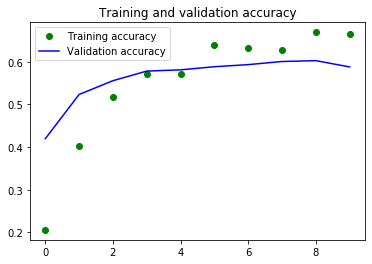

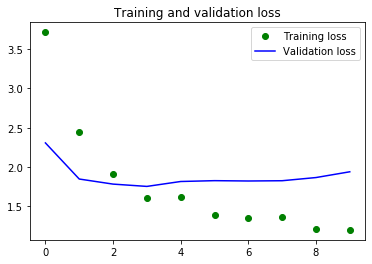

In [14]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy',color='green')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='blue')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss', color='green')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='blue')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Visualizing the models activation layers

In [15]:
img_path = '/content/train/01de1f7b7b4465a6d130a56746af66a6.jpg'
#img_path = '/content/train/75fe24028284a2ba927e6fd111510aa3.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Shape of the image
print(img_tensor.shape)

(1, 224, 224, 3)


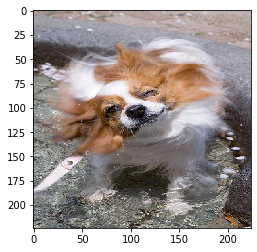

In [16]:
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# Outputs of the first 12 layers
layer_outputs = [layer.output for layer in model.layers[0].layers[1:12]]
# creates an activation model
activation_model = keras.models.Model(inputs=resnet.inputs, outputs=layer_outputs)

In [0]:
# Numpy array
activations = activation_model.predict(img_tensor)

In [19]:
# looking at the first layer of 65
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 112, 112, 64)


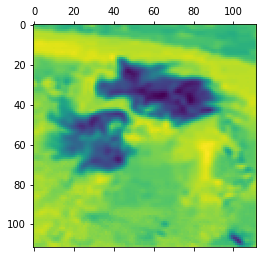

In [20]:
# show first activation layer
plt.matshow(first_layer_activation[0, :, :, 2])

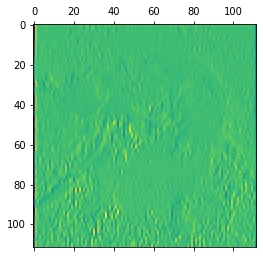

In [21]:
# show first activation layer 
plt.matshow(first_layer_activation[0, :, :, 23], cmap='viridis')
plt.show()

# Feed forward visualization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: ignored

<Figure size 1152x0 with 1 Axes>

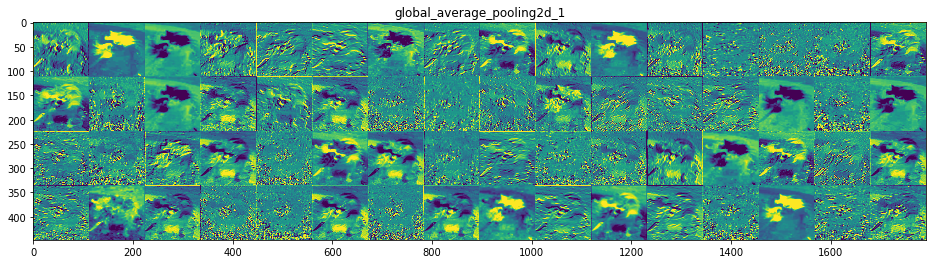

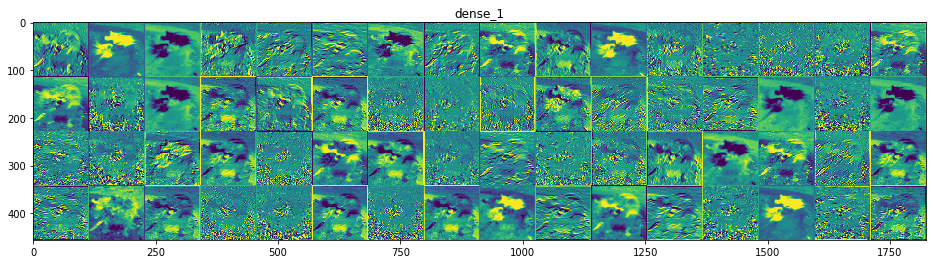

In [22]:
layer_name = []
for layer in model.layers[:12]:
    layer_name.append(layer.name)

images_per_row = 16

# Display of feature maps
for name, layer_act in zip(layer_name, activations):
    # Nnum of features that are in the feature map 
    n_features = layer_act.shape[-1]

    # shape = 1, 224, 224, n_features
    size = layer_act.shape[1]

    # activation layer matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Create the horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            chan_imag = layer_act[0, :, :, col * images_per_row + row]
            chan_imag -= chan_imag.mean()
            chan_imag /= chan_imag.std()
            chan_imag *= 64
            chan_imag += 128
            chan_imag = np.clip(chan_imag, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = chan_imag

    # scale and output the data 
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [0]:
# creating resnet model with same weights as above model to begin visualizing
model = ResNet50V2(weights='imagenet',
                   include_top=False)

layer_name = 'conv5_block3_out'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [27]:
# looking at the gradients
grads = K.gradients(loss, model.input)[0]
print(grads)


Tensor("gradients/conv1_pad_1/Pad_grad/Slice_1:0", shape=(?, ?, ?, 3), dtype=float32)


In [0]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)

In [0]:
iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
#s start with grey scale
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Look at 50 gradient assents 
step = 1.
for i in range(50):
    # find the loss
    loss_value, grads_value = iterate([input_img_data])
    # Maximize loss
    input_img_data += grads_value * step

In [0]:
def decompress_image(x):
    # center on zero
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to the colorfull rgb array of images
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Loss function construction
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Use loss to calculate gradients
    grads = K.gradients(loss, model.input)[0]

    # Normalize and make sure cannot divide by zero
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # Mskes loss and gradients 
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Look at 50 gradient assents 
    step = 1.
    for i in range(50):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return decompress_image(img)

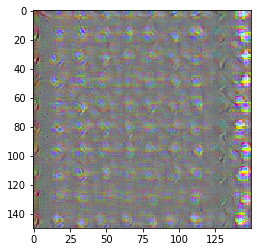

In [33]:
plt.imshow(generate_pattern('conv4_block1_out', 0))
plt.show()

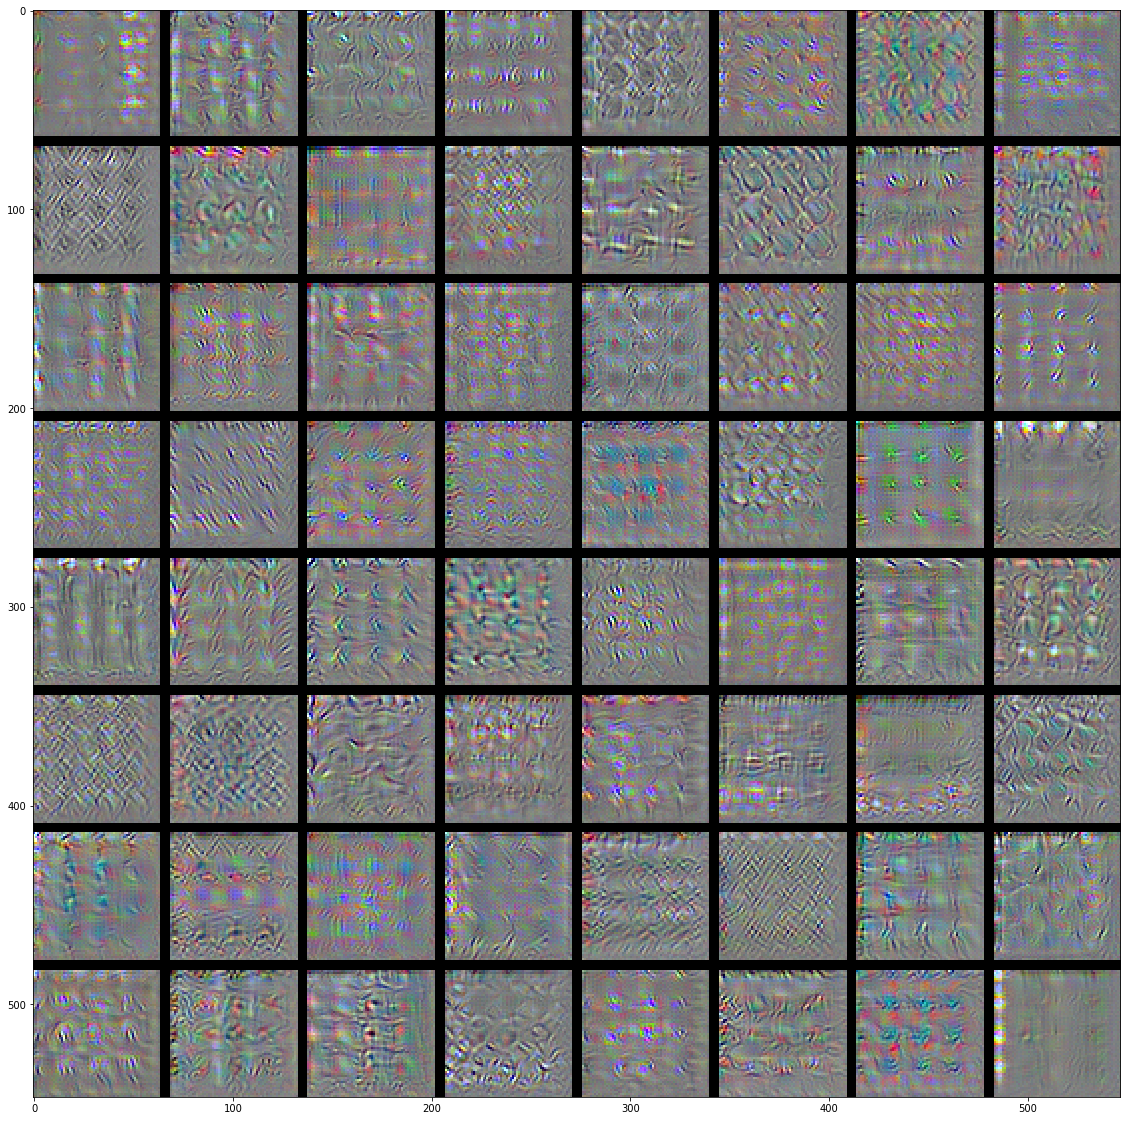

In [34]:
for layer_name in ['conv4_block1_out']:# 'conv4_block3_out', 'conv4_block4_out', 'conv4_block5_out', 'conv4_block6_out']:
    size = 64
    margin = 5

    # Black initial frame to start from 
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
    # iterate over rows and columns 
    for i in range(8):
        for j in range(8):
            # Create the filter
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Return the grid of different images 
    results /= 255.
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [0]:
K.clear_session()
# reset the resnet model 
model = VGG16(weights='imagenet')

In [0]:
#load image
img = image.load_img(img_path, target_size=(224, 224))

# reshape
x = image.img_to_array(img)

# transform array
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [37]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5))

Predicted: [[('n02086910', 'papillon', 0.75945437), ('n02112018', 'Pomeranian', 0.10542959), ('n02105855', 'Shetland_sheepdog', 0.05620027), ('n02085782', 'Japanese_spaniel', 0.024762986), ('n02086646', 'Blenheim_spaniel', 0.010535154)]]


In [38]:
np.argmax(preds[0])

157

In [39]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# vector
_output = model.output[:, 157]

# last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# gradient
grads = K.gradients(_output, last_conv_layer.output)[0]

combined_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [combined_grads, last_conv_layer.output[0]])

combined_grads_value, conv_layer_output = iterate([x])
for i in range(512):
    conv_layer_output[:, :, i] *= combined_grads_value[i]

heatmap = np.mean(conv_layer_output, axis=-1)

In [41]:
heatmap

array([[ 7.52416611e-07, -3.38912230e-07,  2.98270834e-06,
         2.82831002e-06,  1.90985838e-06,  9.62132617e-07,
         9.84766416e-07,  5.71866622e-07,  8.64737729e-07,
         8.69339601e-07,  1.39126428e-07, -6.52003791e-07,
        -1.49140487e-06, -8.30089107e-07],
       [ 2.26620003e-07,  9.66437483e-07,  2.76617726e-07,
         1.39665204e-07,  2.29543389e-07, -1.65909000e-06,
        -1.68042425e-06, -5.25396104e-07,  8.61427907e-07,
        -1.60127456e-07, -3.63853985e-07, -8.41938629e-07,
        -9.80565233e-07, -1.77526533e-06],
       [-4.38091490e-07,  4.07283835e-07,  2.30161777e-06,
         4.88666001e-06,  1.97141640e-06,  3.82183589e-06,
         6.44817101e-06,  7.43625515e-06,  1.00204043e-05,
         9.80407276e-06,  4.26001998e-06,  2.36214532e-07,
        -2.58432306e-06, -2.71220597e-06],
       [-6.63499293e-07, -7.26655117e-07,  7.35083313e-06,
         1.30544340e-05,  3.83078532e-06, -2.30130263e-06,
        -5.50941513e-06, -7.48598177e-06, -3.

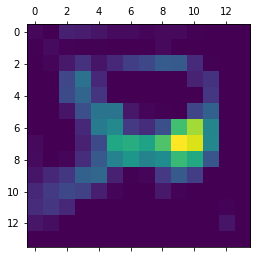

In [42]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()


In [45]:
import cv2
from google.colab.patches import cv2_imshow

if not os.path.exists('/content/pics/'):
  os.system('mkdir /content/pics')

# We use cv2 to load the original image
img = cv2.imread(img_path)

# resize
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# convert to RGB
heatmap = np.uint8(255 * heatmap)

# add heatmap data to original photo
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# heatmap intensity
superimposed_img = heatmap * 0.6 + img

# Save to disk
cv2.imwrite('/content/pics/dog_heatmap.jpg', superimposed_img)


True

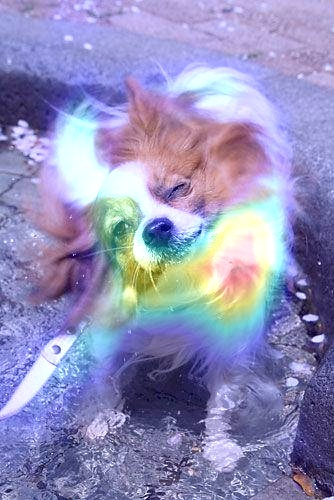

In [44]:
Image('/content/pics/dog_heatmap.jpg', width=250, height=400)